In [1]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools
import time
from tqdm import tqdm
import random

# Custom libraries
import prelim_analysis_utils as pa

In [131]:
# Reload modules in case of modifications
reload(pa)

<module 'prelim_analysis_utils' from '/home/louiscam/projects/gpcr/code/preliminary_analysis/prelim_analysis_gene_level_intraX/prelim_analysis_utils.py'>

# Data directories

In [3]:
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'

In [4]:
# Specify directories and relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Adhesome genes location

In [5]:
# Load adhesome components data
adhesome_components_filename = dir_adhesome+'components.csv'
df_components = pa.load_adhesome_data(adhesome_components_filename)
all_adhesome_genes = np.array(df_components['geneSymbol'])

In [6]:
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = pa.get_gene_locations(gene_locations_filename, gene_id_filename)
df_loc['in_adhesome'] = df_loc['geneSymbol'].isin(all_adhesome_genes)

In [7]:
# Find location of adhesome genes
adhesome_loc_df, missing_adhesome_genes = pa.get_adhesome_genes_location(df_components, df_loc)
adhesome_loc_df = pa.get_adhesome_genes_loci(adhesome_loc_df, resol)

Adhesome genes absent from UCSC genes: ['PPP2CA', 'JUB', 'GRLF1', 'ARHGEF6', 'SMPX', 'DDEF1', 'ITGAW', 'FLNA', 'MSN', 'SH3KBP1']


In [8]:
# Add column specifying chromosome number as an int
adhesome_chr_loci = adhesome_loc_df[['gene','chrom','loci']]
adhesome_chr_loci['chrom_int'] = adhesome_chr_loci['chrom'].str.split('chr').str[1].astype(int)
adhesome_chr_loci = adhesome_chr_loci.sort_values(['chrom_int','loci'])

In [9]:
# Also create dataframe with chromosome information for each adhesome gene
adhesome_chr = adhesome_chr_loci.drop_duplicates(subset='gene', keep='first')

# Matrix of adhesome gene Hi-C contacts

In [47]:
# Choose chromosome
chr0 = 22

In [48]:
# Create matrix of adhesome genes Hi-C contacts
gene_contacts_df = pa.build_adhesome_gene_contact_mat(chr0, adhesome_chr_loci, dir_processed_hic, resol)
gene_contacts_df = gene_contacts_df+gene_contacts_df.transpose()

Number of adhesome genes on chromosome 22: 7
Number of adhesome gene pairs on chromosome 22: 21


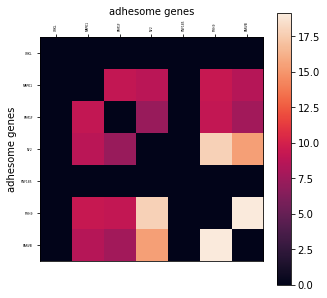

In [49]:
# Plot matrix as heatmap
gene_list = list(gene_contacts_df.columns)
print('Number of adhesome genes on chromosome '+str(chr0)+': '+str(len(gene_list)))
print('Number of adhesome gene pairs on chromosome '+str(chr0)+': '+str(int(len(gene_list)*(len(gene_list)-1)/2)))
pa.plot_heatmap(gene_contacts_df, gene_list, gene_list,'adhesome genes', 'adhesome genes', 5, gene_contacts_df.max().max())

In [51]:
# Transform the gene Hi-C contact dataframe to (index, column, value format)
new_index = pd.MultiIndex.from_tuples(itertools.combinations(gene_contacts_df.index.tolist(), 2),
                                      names=["column","index"])
gene_contacts_df1 = gene_contacts_df.stack().reindex(new_index).reset_index(name='hic_contact')

### Compare to random genes

In [52]:
# Restrict df_loc to chr0
df_loc_chr0 = df_loc[df_loc['#chrom']=='chr'+str(chr0)]
# Number of adhesome genes and non adhesome genes on chr0
n_adh_genes = len(df_loc_chr0[df_loc_chr0['in_adhesome']==True])
n_non_adh_genes = len(df_loc_chr0[df_loc_chr0['in_adhesome']==False])

In [53]:
# Number of adhesome and non adhesome genes
random.seed(13)
df_rand = df_loc_chr0[df_loc_chr0['in_adhesome']==False]
df_rand = df_rand.iloc[random.sample(range(n_non_adh_genes), n_adh_genes),[1,2,3,4]]
df_rand.columns = ['gene','chrom','genoStart','genoEnd']
df_rand['geneLength'] = df_rand['genoEnd']-df_rand['genoStart']
df_rand = df_rand.reset_index(drop=True)

In [54]:
# Find the corresponding loci
rand_loc_df = pa.get_adhesome_genes_loci(df_rand, resol)
rand_chr_loci = rand_loc_df.iloc[:,[0,1,2]]
rand_chr_loci['chrom_int'] = rand_loc_df['chrom'].str.split('chr').str[1].astype(int)
rand_chr_loci = rand_chr_loci.sort_values(['loci'])
# Create matrix of random genes Hi-C contacts
gene_contacts_df_rand = pa.build_adhesome_gene_contact_mat(chr0, rand_chr_loci, 
                                                      dir_processed_hic, resol)
gene_contacts_df_rand = gene_contacts_df_rand+gene_contacts_df_rand.transpose()

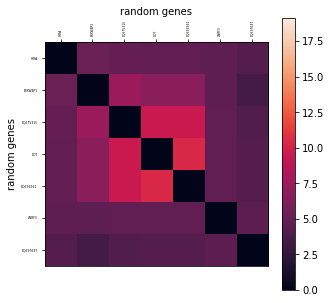

In [55]:
# Plot matrix as heatmap
gene_list_rand = list(gene_contacts_df_rand.columns)
pa.plot_heatmap(gene_contacts_df_rand, gene_list_rand, gene_list_rand,'random genes', 'random genes', 5, gene_contacts_df.max().max())

Mean Hi-C between adhesome genes = 4.5934069033468505
Mean Hi-C between random genes = 4.858957394447428


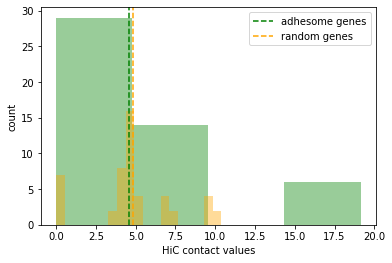

In [56]:
# Compare distributions
plt.figure()
sns.distplot(gene_contacts_df.values.flatten(), 
             kde=False, hist=True, 
             color='green',
             axlabel='HiC contact values', label='HiC intraX contacts between adhesome genes')
plt.axvline(np.mean(gene_contacts_df.values.flatten()), color='green', linestyle='dashed')
print('Mean Hi-C between adhesome genes = '+str(np.mean(gene_contacts_df.values.flatten())))
sns.distplot(gene_contacts_df_rand.values.flatten(), 
             kde=False, hist=True, 
             color='orange',
             axlabel='HiC contact values', label='HiC intraX contacts between random genes')
plt.axvline(np.mean(gene_contacts_df_rand.values.flatten()), color='orange', linestyle='dashed')
print('Mean Hi-C between random genes = '+str(np.mean(gene_contacts_df_rand.values.flatten())))
plt.ylabel('count')
plt.legend(['adhesome genes','random genes'], loc='upper right')
plotname = 'adhesome_random_hic_contacts_interX_genes'+'.pdf'
#plt.savefig(prelim_results_dir+plotname, format='pdf')
plt.show()

In [57]:
# Store adhesome gene pairs with highest Hi-C contact values as pickle
threshold = np.quantile(gene_contacts_df1['hic_contact'], 0.9)
top_adhesome_gene_pairs = gene_contacts_df1[gene_contacts_df1['hic_contact']>threshold].sort_values(by='hic_contact', ascending=False)
print(len(top_adhesome_gene_pairs))
pickle.dump(top_adhesome_gene_pairs, open(prelim_results_dir+'top_adhesome_gene_pairs_intraX_chr'+str(chr0)+'.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

2


# Adhesome network interactions

### Histogram of effects and types of interactions across all chromosomes

In [58]:
# Load interactions
interactions_filename = 'interactions.csv'
df_interactions = pd.read_csv(dir_adhesome+interactions_filename, sep = ',', header = 0)
df_interactions['Type'] = df_interactions['Type'].str.lower().str.replace('_reaction','')

In [59]:
# Remove missing genes from edge list
df_interactions = df_interactions[~df_interactions['Source'].isin(missing_adhesome_genes)]
df_interactions = df_interactions[~df_interactions['Target'].isin(missing_adhesome_genes)]

In [60]:
# Remove non-adhesome genes from edge list (e.g. calcium)
adhesome_genes = np.array(adhesome_chr.gene)
df_interactions = df_interactions[df_interactions['Source'].isin(adhesome_genes)]
df_interactions = df_interactions[df_interactions['Target'].isin(adhesome_genes)]

In [61]:
# Add chromosome information for source and target genes
df_interactions = pd.merge(df_interactions, adhesome_chr[['gene','chrom']].add_suffix('_source'), 
                       how='inner', left_on='Source', right_on='gene_source')
df_interactions = pd.merge(df_interactions, adhesome_chr[['gene','chrom']].add_suffix('_target'), 
                       how='inner', left_on='Target', right_on='gene_target')
df_interactions = df_interactions.drop(['gene_source','gene_target'], axis=1)
df_interactions['same_chrom'] = df_interactions['chrom_source']==df_interactions['chrom_target']

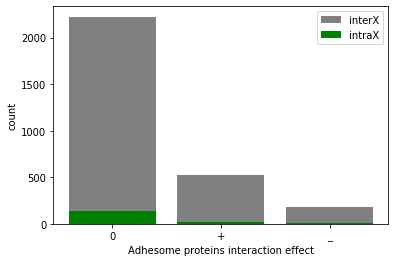

In [62]:
# Histogram of edge effects
df_interactions_interX_effect = df_interactions[df_interactions['same_chrom']==False].drop_duplicates(subset=['Source','Target','Effect'],keep='first').Effect.value_counts()
df_interactions_intraX_effect = df_interactions[df_interactions['same_chrom']==True].drop_duplicates(subset=['Source','Target','Effect'],keep='first').Effect.value_counts()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x = list(df_interactions_interX_effect.index), height = df_interactions_interX_effect, color='grey')
ax.bar(x = list(df_interactions_intraX_effect.index), height = df_interactions_intraX_effect, color='green')
plt.xlabel('Adhesome proteins interaction effect')
plt.ylabel('count')
plt.legend(['interX', 'intraX'], loc='upper right')
plt.show()

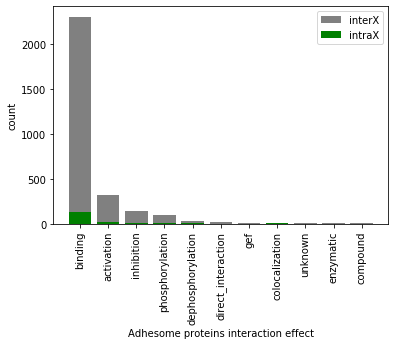

In [63]:
# Histogram of edge types
df_interactions_interX_type = df_interactions[df_interactions['same_chrom']==False].drop_duplicates(subset=['Source','Target','Type'],keep='first').Type.value_counts()
df_interactions_intraX_type = df_interactions[df_interactions['same_chrom']==True].drop_duplicates(subset=['Source','Target','Type'],keep='first').Type.value_counts()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x = list(df_interactions_interX_type.index), height = df_interactions_interX_type, color='grey')
ax.bar(x = list(df_interactions_intraX_type.index), height = df_interactions_intraX_type, color='green')
plt.xlabel('Adhesome proteins interaction effect')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.legend(['interX', 'intraX'], loc='upper right')
plt.show()

### Adhesome interactions specific to chr0

In [115]:
# Load interactions
interactions_filename = 'interactions.csv'
df_interactions = pd.read_csv(dir_adhesome+interactions_filename, sep = ',', header = 0)
df_interactions['Type'] = df_interactions['Type'].str.lower().str.replace('_reaction','')

In [116]:
# Remove missing genes from edge list
df_interactions = df_interactions[~df_interactions['Source'].isin(missing_adhesome_genes)]
df_interactions = df_interactions[~df_interactions['Target'].isin(missing_adhesome_genes)]

In [117]:
# Remove non-genes from edge list (e.g. calcium)
df_interactions = df_interactions[df_interactions['Source'].isin(adhesome_genes)]
df_interactions = df_interactions[df_interactions['Target'].isin(adhesome_genes)]

In [118]:
# Add chromosome information for source and target genes
df_interactions = pd.merge(df_interactions, adhesome_chr[['gene','chrom']].add_suffix('_source'), 
                       how='inner', left_on='Source', right_on='gene_source')
df_interactions = pd.merge(df_interactions, adhesome_chr[['gene','chrom']].add_suffix('_target'), 
                       how='inner', left_on='Target', right_on='gene_target')
df_interactions = df_interactions.drop(['gene_source','gene_target'], axis=1)
df_interactions['same_chrom'] = df_interactions['chrom_source']==df_interactions['chrom_target']

In [119]:
# Only select intraX interactions
df_interactions = df_interactions[df_interactions['same_chrom']==True]

In [120]:
# Only select intraX interactions on chr0
df_interactions = df_interactions[df_interactions['chrom_source']=='chr'+str(chr0)]
df_interactions = df_interactions.drop_duplicates(subset=['Source','Target','Effect','Type'], 
                                                  keep='first')

# ROC based on interaction effect

In [121]:
# Distribution of effects
df_interactions.Effect.value_counts()

Series([], Name: Effect, dtype: int64)

In [122]:
interaction_effects = np.unique(df_interactions['Effect'])

# Initialize empty figure
grid_size = [1,3]
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
effect_count = 0

for effect in interaction_effects:
    effect_count += 1
    
    # Only keep rows corresponding to effect
    df_interactions1 = df_interactions[df_interactions['Effect']==effect]
    # Drop duplicate rows based on source and target protein
    df_interactions1 = df_interactions1.drop_duplicates(subset=['Source','Target'], keep='first')
    

    # Create networkX adhesome network without node attributes
    adhesome_network = nx.from_pandas_edgelist(df_interactions1, 'Source', 'Target', 
                                            ['Effect', 'Type', 'PMID', 'data_source'])

    # Transform the adhesome network adjacency matrix to (index, column, value format)
    adhesome_network_df = nx.to_pandas_adjacency(adhesome_network, dtype=int)
    new_index = pd.MultiIndex.from_tuples(itertools.product(adhesome_network_df.index.tolist(),
                                                            adhesome_network_df.index.tolist()),
                                          names=["column","index"])
    adhesome_network_df1 = adhesome_network_df.stack().reindex(new_index).reset_index(name='edge')

    # Join gene_contacts_full_df1 and adhesome_network_df1
    combined_df = pd.merge(gene_contacts_df1, adhesome_network_df1, 
                           how='left', on=['column','index'])
    combined_df = combined_df.fillna(0)
    combined_df = combined_df.sort_values(by='hic_contact', ascending=False)
    
    # Plot ROC curve
    ax = fig.add_subplot(grid_size[0], grid_size[1], effect_count)
    plt.plot(np.arange(len(combined_df))+1,np.cumsum(combined_df['edge']), color='green')
    plt.plot([0,len(combined_df)],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    plt.plot([0,np.sum(combined_df['edge'])],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    plt.plot([len(combined_df)-np.sum(combined_df['edge']),len(combined_df)],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    ax.set_xlabel('Gene pairs in decreasing order of Hi-C contact value')
    ax.set_ylabel('Number of edges in the adjacency matrix')
    ax.set_title(effect)

plt.show()


<Figure size 1440x360 with 0 Axes>

# ROC based on interaction type

In [123]:
# Distribution of interaction types
df_interactions.Type.value_counts()

Series([], Name: Type, dtype: int64)

In [124]:
interaction_types = np.unique(df_interactions['Type'])

# Initialize empty figure
grid_size = [4,3]
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
type_count = 0

for int_type in interaction_types:
    type_count += 1
    
    # Only keep rows corresponding to effect
    df_interactions1 = df_interactions[df_interactions['Type']==int_type]
    # Drop duplicate rows based on source and target protein
    df_interactions1 = df_interactions1.drop_duplicates(subset=['Source','Target'], keep='first')
    

    # Create networkX adhesome network without node attributes
    adhesome_network = nx.from_pandas_edgelist(df_interactions1, 'Source', 'Target', 
                                            ['Effect', 'Type', 'PMID', 'data_source'])

    # Transform the adhesome network adjacency matrix to (index, column, value format)
    adhesome_network_df = nx.to_pandas_adjacency(adhesome_network, dtype=int)
    new_index = pd.MultiIndex.from_tuples(itertools.product(adhesome_network_df.index.tolist(),
                                                            adhesome_network_df.index.tolist()),
                                          names=["column","index"])
    adhesome_network_df1 = adhesome_network_df.stack().reindex(new_index).reset_index(name='edge')

    # Join gene_contacts_full_df1 and adhesome_network_df1
    combined_df = pd.merge(gene_contacts_df1, adhesome_network_df1, 
                           how='left', on=['column','index'])
    combined_df = combined_df.fillna(0)
    combined_df = combined_df.sort_values(by='hic_contact', ascending=False)
    print(combined_df[combined_df['edge']==1])
    
    # Plot ROC curve
    ax = fig.add_subplot(grid_size[0], grid_size[1], type_count)
    plt.plot(np.arange(len(combined_df))+1,np.cumsum(combined_df['edge']), color='green')
    plt.plot([0,len(combined_df)],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    plt.plot([0,np.sum(combined_df['edge'])],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    plt.plot([len(combined_df)-np.sum(combined_df['edge']),len(combined_df)],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    ax.set_xlabel('Gene pairs in decreasing order of Hi-C contact value')
    ax.set_ylabel('Number of edges in the adjacency matrix')
    ax.set_title(int_type)

plt.show()


<Figure size 1440x1440 with 0 Axes>

# Produce all plots for a given chromosome

Number of adhesome genes on chromosome 22: 7
Number of adhesome gene pairs on chromosome 22: 21


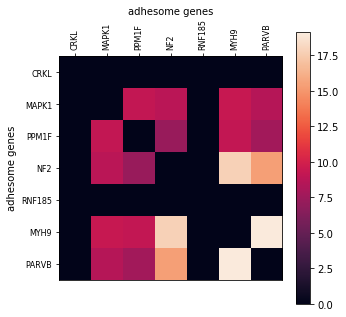

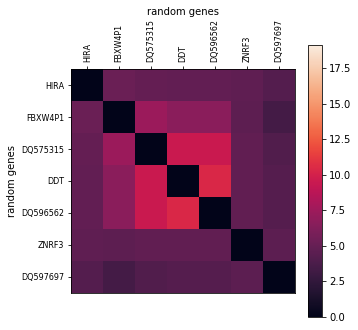

Mean Hi-C between adhesome genes = 4.5934069033468505
Mean Hi-C between random genes = 4.858957394447428


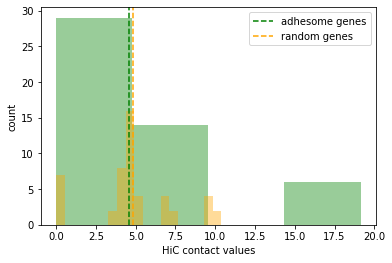

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [156]:
chr0 = 22

# Create matrix of adhesome genes Hi-C contacts
gene_contacts_df = pa.build_adhesome_gene_contact_mat(chr0, adhesome_chr_loci, dir_processed_hic, resol)
gene_contacts_df = gene_contacts_df+gene_contacts_df.transpose()

# Plot matrix as heatmap
gene_list = list(gene_contacts_df.columns)
print('Number of adhesome genes on chromosome '+str(chr0)+': '+str(len(gene_list)))
print('Number of adhesome gene pairs on chromosome '+str(chr0)+': '+str(int(len(gene_list)*(len(gene_list)-1)/2)))
pa.plot_heatmap(gene_contacts_df, gene_list, gene_list,'adhesome genes', 'adhesome genes', 5, gene_contacts_df.max().max(), fontsize=8)

# Transform the gene Hi-C contact dataframe to (index, column, value format)
new_index = pd.MultiIndex.from_tuples(itertools.combinations(gene_contacts_df.index.tolist(), 2),
                                      names=["column","index"])
gene_contacts_df1 = gene_contacts_df.stack().reindex(new_index).reset_index(name='hic_contact')

# Restrict df_loc to chr0
df_loc_chr0 = df_loc[df_loc['#chrom']=='chr'+str(chr0)]
# Number of adhesome genes and non adhesome genes on chr0
n_adh_genes = len(df_loc_chr0[df_loc_chr0['in_adhesome']==True])
n_non_adh_genes = len(df_loc_chr0[df_loc_chr0['in_adhesome']==False])
# Number of adhesome and non adhesome genes
random.seed(13)
df_rand = df_loc_chr0[df_loc_chr0['in_adhesome']==False]
df_rand = df_rand.iloc[random.sample(range(n_non_adh_genes), n_adh_genes),[1,2,3,4]]
df_rand.columns = ['gene','chrom','genoStart','genoEnd']
df_rand['geneLength'] = df_rand['genoEnd']-df_rand['genoStart']
df_rand = df_rand.reset_index(drop=True)
# Find the corresponding loci
rand_loc_df = pa.get_adhesome_genes_loci(df_rand, resol)
rand_chr_loci = rand_loc_df.iloc[:,[0,1,2]]
rand_chr_loci['chrom_int'] = rand_loc_df['chrom'].str.split('chr').str[1].astype(int)
rand_chr_loci = rand_chr_loci.sort_values(['loci'])
# Create matrix of random genes Hi-C contacts
gene_contacts_df_rand = pa.build_adhesome_gene_contact_mat(chr0, rand_chr_loci, 
                                                      dir_processed_hic, resol)
gene_contacts_df_rand = gene_contacts_df_rand+gene_contacts_df_rand.transpose()
# Plot matrix as heatmap
gene_list_rand = list(gene_contacts_df_rand.columns)
pa.plot_heatmap(gene_contacts_df_rand, gene_list_rand, gene_list_rand,'random genes', 'random genes', 5, gene_contacts_df.max().max(), fontsize=8)

# Compare distributions
plt.figure()
sns.distplot(gene_contacts_df.values.flatten(), 
             kde=False, hist=True, 
             color='green',
             axlabel='HiC contact values', label='HiC intraX contacts between adhesome genes')
plt.axvline(np.mean(gene_contacts_df.values.flatten()), color='green', linestyle='dashed')
print('Mean Hi-C between adhesome genes = '+str(np.mean(gene_contacts_df.values.flatten())))
sns.distplot(gene_contacts_df_rand.values.flatten(), 
             kde=False, hist=True, 
             color='orange',
             axlabel='HiC contact values', label='HiC intraX contacts between random genes')
plt.axvline(np.mean(gene_contacts_df_rand.values.flatten()), color='orange', linestyle='dashed')
print('Mean Hi-C between random genes = '+str(np.mean(gene_contacts_df_rand.values.flatten())))
plt.ylabel('count')
plt.legend(['adhesome genes','random genes'], loc='upper right')
plotname = 'adhesome_random_hic_contacts_interX_genes'+'.pdf'
#plt.savefig(prelim_results_dir+plotname, format='pdf')
plt.show()

# Load interactions
interactions_filename = 'interactions.csv'
df_interactions = pd.read_csv(dir_adhesome+interactions_filename, sep = ',', header = 0)
df_interactions['Type'] = df_interactions['Type'].str.lower().str.replace('_reaction','')
# Remove missing genes from edge list
df_interactions = df_interactions[~df_interactions['Source'].isin(missing_adhesome_genes)]
df_interactions = df_interactions[~df_interactions['Target'].isin(missing_adhesome_genes)]
# Remove non-genes from edge list (e.g. calcium)
df_interactions = df_interactions[df_interactions['Source'].isin(adhesome_genes)]
df_interactions = df_interactions[df_interactions['Target'].isin(adhesome_genes)]
# Add chromosome information for source and target genes
df_interactions = pd.merge(df_interactions, adhesome_chr[['gene','chrom']].add_suffix('_source'), 
                       how='inner', left_on='Source', right_on='gene_source')
df_interactions = pd.merge(df_interactions, adhesome_chr[['gene','chrom']].add_suffix('_target'), 
                       how='inner', left_on='Target', right_on='gene_target')
df_interactions = df_interactions.drop(['gene_source','gene_target'], axis=1)
df_interactions['same_chrom'] = df_interactions['chrom_source']==df_interactions['chrom_target']
# Only select intraX interactions
df_interactions = df_interactions[df_interactions['same_chrom']==True]
# Only select intraX interactions on chr0
df_interactions = df_interactions[df_interactions['chrom_source']=='chr'+str(chr0)]
df_interactions = df_interactions.drop_duplicates(subset=['Source','Target','Effect','Type'], 
                                                  keep='first')

interaction_effects = np.unique(df_interactions['Effect'])

# Initialize empty figure
grid_size = [1,3]
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
effect_count = 0

# ROC based on effect
for effect in interaction_effects:
    effect_count += 1
    
    # Only keep rows corresponding to effect
    df_interactions1 = df_interactions.copy()
    df_interactions1 = df_interactions1[df_interactions1['Effect']==effect]
    # Drop duplicate rows based on source and target protein
    df_interactions1 = df_interactions1.drop_duplicates(subset=['Source','Target'], keep='first')
    

    # Create networkX adhesome network without node attributes
    adhesome_network = nx.from_pandas_edgelist(df_interactions1, 'Source', 'Target', 
                                            ['Effect', 'Type', 'PMID', 'data_source'])

    # Transform the adhesome network adjacency matrix to (index, column, value format)
    adhesome_network_df = nx.to_pandas_adjacency(adhesome_network, dtype=int)
    new_index = pd.MultiIndex.from_tuples(itertools.product(adhesome_network_df.index.tolist(),
                                                            adhesome_network_df.index.tolist()),
                                          names=["column","index"])
    adhesome_network_df1 = adhesome_network_df.stack().reindex(new_index).reset_index(name='edge')
    
    # Join gene_contacts_full_df1 and adhesome_network_df1
    combined_df = pd.merge(gene_contacts_df1, adhesome_network_df1, 
                           how='left', on=['column','index'])
    combined_df = combined_df.fillna(0)
    combined_df = combined_df.sort_values(by='hic_contact', ascending=False)
    
    # Plot ROC curve
    ax = fig.add_subplot(grid_size[0], grid_size[1], effect_count)
    plt.plot(np.arange(len(combined_df))+1,np.cumsum(combined_df['edge']), color='green')
    plt.plot([0,len(combined_df)],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    plt.plot([0,np.sum(combined_df['edge'])],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    plt.plot([len(combined_df)-np.sum(combined_df['edge']),len(combined_df)],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    ax.set_xlabel('Gene pairs in decreasing order of Hi-C contact value')
    ax.set_ylabel('Number of edges in the adjacency matrix')
    ax.set_title(effect)

plt.show()

# ROC based on type
interaction_types = np.unique(df_interactions['Type'])

# Initialize empty figure
grid_size = [4,3]
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
type_count = 0

for int_type in interaction_types:
    type_count += 1
    
    # Only keep rows corresponding to effect
    df_interactions1 = df_interactions.copy()
    df_interactions1 = df_interactions1[df_interactions1['Type']==int_type]
    # Drop duplicate rows based on source and target protein
    df_interactions1 = df_interactions1.drop_duplicates(subset=['Source','Target'], keep='first')
    

    # Create networkX adhesome network without node attributes
    adhesome_network = nx.from_pandas_edgelist(df_interactions1, 'Source', 'Target', 
                                            ['Effect', 'Type', 'PMID', 'data_source'])

    # Transform the adhesome network adjacency matrix to (index, column, value format)
    adhesome_network_df = nx.to_pandas_adjacency(adhesome_network, dtype=int)
    new_index = pd.MultiIndex.from_tuples(itertools.product(adhesome_network_df.index.tolist(),
                                                            adhesome_network_df.index.tolist()),
                                          names=["column","index"])
    adhesome_network_df1 = adhesome_network_df.stack().reindex(new_index).reset_index(name='edge')

    # Join gene_contacts_full_df1 and adhesome_network_df1
    combined_df = pd.merge(gene_contacts_df1, adhesome_network_df1, 
                           how='left', on=['column','index'])
    combined_df = combined_df.fillna(0)
    combined_df = combined_df.sort_values(by='hic_contact', ascending=False)
    print(combined_df[combined_df['edge']==1])
    
    # Plot ROC curve
    ax = fig.add_subplot(grid_size[0], grid_size[1], type_count)
    plt.plot(np.arange(len(combined_df))+1,np.cumsum(combined_df['edge']), color='green')
    plt.plot([0,len(combined_df)],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    plt.plot([0,np.sum(combined_df['edge'])],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    plt.plot([len(combined_df)-np.sum(combined_df['edge']),len(combined_df)],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
    ax.set_xlabel('Gene pairs in decreasing order of Hi-C contact value')
    ax.set_ylabel('Number of edges in the adjacency matrix')
    ax.set_title(int_type)

plt.show()


In [128]:
gene_list

['ANKRD28',
 'ITGA9',
 'RHOA',
 'PPM1M',
 'NISCH',
 'CD47',
 'ITGB5',
 'PLD1',
 'PIK3CA',
 'LPP']